# MNIST from scratch with numpy

In [1]:
# load changed modules automatically
%reload_ext autoreload
%autoreload 2

In [2]:
# load numpy
import numpy as np

# load dataloaders and required layers
from mnist import dataloader
from mnist.layers import Softmax, Linear, Dropout, ReLU
from mnist.losses import CrossEntropy

# load pyplot for displaying images
from matplotlib import pyplot as plt

# show images inline on notebook
%matplotlib inline

# debugging
import pdb

## Load training data

In [3]:
dl = dataloader.DataLoader()
((x_train, y_train), (x_valid, y_valid), (x_test, (y_test))) = dl.load_data()

In [4]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((50000, 784), (50000,), (10000, 784), (10000,))

## Normalize data

In [5]:
(x_train, y_train), (x_valid, y_valid) = dl.normalize(((x_train, y_train), (x_valid, y_valid)))

## Exploring the data

In [11]:
def show(img):
    plt.imshow(img, cmap="gray")

In [ ]:
valid_images = np.reshape(x_valid, (-1,28,28))

In [ ]:
show(valid_images[0])

## Start building the model

In [6]:
def shuffle(arr1, arr2):
    random_idxs = np.arange(len(arr1))
    np.random.shuffle(random_idxs)
    return arr1[random_idxs], arr2[random_idxs]

In [7]:
# always reproduce the same weights
np.random.seed(1)

class Net(object):
    def __init__(self, n_input=28*28, n_hidden=256, n_output=10):
        self.train = True
        
        self.input_dropout = Dropout(0.01)
        self.input_layer = Linear(n_input, n_hidden)
        
        self.dropout1 = Dropout(0.5)
        self.hidden1 = Linear(n_hidden, n_output)

        self.relu = ReLU()
        self.softmax = Softmax()
        self.cross_entropy = CrossEntropy()
    
    def forward(self, x):
        if self.train:
            x = self.input_dropout.forward(x)

        x = self.input_layer.forward(x)
        x = self.relu.forward(x)

        if self.train:
            x = self.dropout1.forward(x)

        x = self.hidden1.forward(x)
        x = self.softmax.forward(x)
        return x
    
    def backward(self, targets):
        grads = {}
        
        grad_loss = net.softmax.backward(targets)

        grad_hidden_inputs, grad_hidden_weights, grad_hidden_bias = net.hidden1.backward(grad_loss)
        grads['w2'] = grad_hidden_weights
        grads['b2'] = grad_hidden_bias

        grad_relu = net.relu.backward(grad_hidden_inputs)

        grad_inputs, grad_input_weights, grad_input_bias = net.input_layer.backward(grad_relu)
        grads['w1'] = grad_input_weights
        grads['b1'] = grad_input_bias
        
        return grads
    
    def loss(self, y_pred, y):
        return self.cross_entropy.loss(y_pred, y)

net = Net(n_input=28*28, n_hidden=256, n_output=10)

In [8]:
debug = False

if debug:
    n_epochs = 1
    batch_size = 3
else:
    n_epochs = 10
    batch_size = 256
    
learning_rate = 1e-1

for epoch in range(n_epochs):
    
    for i in range(0, len(x_train), batch_size):

        inputs = x_train[i:i+batch_size]
        targets = y_train[i:i+batch_size]
        
        inputs, targets = shuffle(inputs, targets)

        if debug:
            print("inputs.shape", inputs.shape)
            print("targets.shape", targets.shape)

        # forward propagation
        y_pred = net.forward(inputs)
        predictions = y_pred.copy()

        if debug:
            print("y_pred.shape:", y_pred.shape)
            print("predictions.shape", predictions.shape)
            
        # calculate cross-entropy loss
        loss = net.loss(predictions, targets)
        
        if debug:
            print(epoch, loss)
        
        # backpropagation
        grads = net.backward(targets)
        
        if debug:
            print("w1.shape", grads['w1'].shape)
            print("b1.shape", grads['b1'].shape)
            print("w2.shape", grads['w2'].shape)
            print("b2.shape", grads['b2'].shape)
            
        net.input_layer.weights -= learning_rate * grads['w1']
        net.input_layer.bias -= learning_rate * grads['b1']
        
        net.hidden1.weights -= learning_rate * grads['w2']
        net.hidden1.bias -= learning_rate * grads['b2']

        if debug:
            break
        
    # calculate validation loss for some random indices
    net.train = False
    random_idxs = np.random.randint(0, len(x_valid), batch_size)
    y_valid_pred = net.forward(x_valid[random_idxs])
    loss_valid = net.loss(y_valid_pred, y_valid[random_idxs])
    net.train = True
    
    #calculate accuracy and validation accuracy
    accuracy = np.mean(y_pred.argmax(axis=1) == targets)
    valid_accuracy = np.mean(y_valid_pred.argmax(axis=1) == y_valid[random_idxs])
    
    print(epoch, loss, loss_valid, accuracy, valid_accuracy)


0 0.3906668132819327 0.3243557661436557 0.9 0.90234375
1 0.3260906631377021 0.4547801716592869 0.9125 0.8828125
2 0.25048209278271394 0.12696148926633088 0.925 0.9609375
3 0.16853272794715904 0.18167559469333397 0.9625 0.9453125
4 0.182128664466565 0.2933465308516074 0.95 0.921875
5 0.1057985759784315 0.20774606040480825 0.975 0.94921875
6 0.1460489863382047 0.10863563436643263 0.9375 0.9609375
7 0.19128333736515749 0.2560116427111449 0.925 0.9375
8 0.08659846806244902 0.10788185545750609 0.975 0.953125
9 0.05223984658798355 0.16733635325407153 0.9875 0.9609375


## Check results

In [9]:
# get some random examples from validation data,
# compare predictions with actual values
valid_preds = net.forward(x_valid)
random_idxs = np.random.randint(0, len(x_valid), 10)
np.argmax(valid_preds, axis=1)[random_idxs], y_valid[random_idxs]

(array([3, 4, 2, 3, 0, 0, 3, 5, 6, 4]), array([3, 4, 2, 3, 0, 0, 3, 5, 4, 4]))

prediction: 0 correct: 0


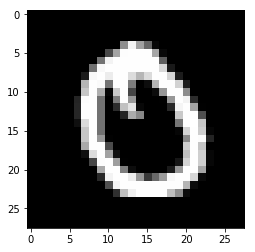

In [12]:
# display a random image from validation data with
# prediction and correct value
valid_images = np.reshape(x_valid, (-1,28,28))
valid_preds = net.forward(x_valid)
random_idx = np.random.randint(0, len(x_valid))
prediction = np.argmax(valid_preds, axis=1)[random_idx]
correct = y_valid[random_idx]
print("prediction:", prediction, "correct:", correct)
show(valid_images[random_idx])

In [13]:
# whole validation set accuracy
valid_preds = net.forward(x_valid)
valid_accuracy = np.mean(valid_preds.argmax(axis=1) == y_valid)
valid_accuracy

0.9484